# Ni and Fe microspectrocopy data from BNL

1. **Fe_xanes** (from HXN) is a model system sample used for optimizing nano-XANES workflow. We know the "true value" chemical state map. The aggregate is composed of 
        a. LiFe(II)PO4 (LFP)

        b. Pyrite (Pyr)

        c. StainlessSteelNP (SS) and

        d. Hematite_NP (Hem).

      *Please note that this is unpublished data from a submitted MS*


2. **Ni_xanes** is NMC?

In [1]:
from ipywidgets import IntSlider, widgets, interactive, fixed

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import wasserstein_distance, pearsonr

import sympy

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib import gridspec
import matplotlib as mpl

import selector
from selector import energy_point_selector
from importlib import reload

import utils
utils = reload(utils)
from utils import *

np.random.seed(42)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Read in data

(101, 320, 320)
(73, 155, 160)


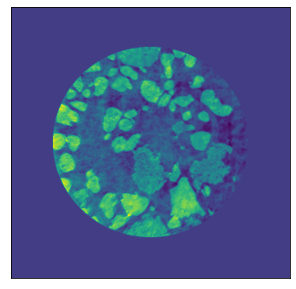

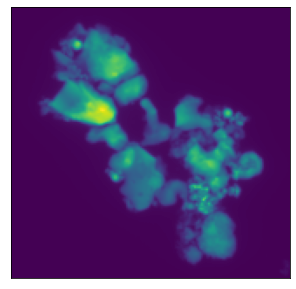

In [3]:
Ni_xanes = parse_tiff('Data/TXM_XANES/Ni_xanes.tiff')
Ni_energy = np.loadtxt('Data/TXM_XANES/Ni_eng_list.txt')

Fe_xanes = parse_tiff('Data/HXN_XANES/nanoXANES_Fe.tiff')
Fe_energy = np.loadtxt('Data/HXN_XANES/energy_list_corr.txt')

def plot_img(data):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(data, extent=[0, 1, 0, 1], aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])

print(Ni_xanes.shape)
print(Fe_xanes.shape)

plot_img(np.average(Ni_xanes, axis=0))
plot_img(np.average(Fe_xanes, axis=0))

In [4]:
expected_results = parse_tiff('Data/HXN_XANES/chemical_map.tiff')
df = pd.read_csv('Data/HXN_XANES/xanes_fit_plot.csv')
df.head()

,Data_x,Data_y,Fit_y,LiFe(II)PO4_y,Pyrite_y,StainlessSteelNP_y,Hematite_NP_y
0,7075.6,2.300333,1.244027,1.237492,-0.075648,-0.161534,0.243717
1,7081.0,2.872172,1.244027,1.237492,-0.075648,-0.161534,0.243717
2,7086.0,3.539921,1.244027,1.237492,-0.075648,-0.161534,0.243717
3,7090.8,4.428800,1.036171,1.061223,-0.085117,-0.148813,0.208878
4,7096.0,5.872788,0.033630,0.058501,-0.020770,-0.019977,0.015876


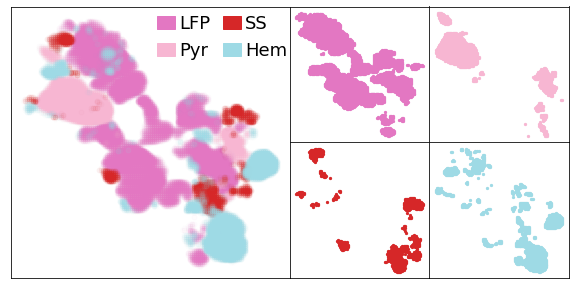

In [5]:
fig = plt.figure(figsize=(10, 5))
spec = fig.add_gridspec(nrows=2, ncols=3,
                        width_ratios=[1, 0.5, 0.5])
plt.subplots_adjust(hspace=0.0, wspace=0.0)

bigax = fig.add_subplot(spec[:2, 0])

labels = ['LFP', 'Pyr', 'SS', 'Hem']
color_labels = [12, 13, 6, 19]

for i, img in enumerate(expected_results):
    row = i // 2
    colm = i % 2 + row // 2
    ax = fig.add_subplot(spec[row, colm + 1])
    
    threshold = 0.025
    mask = np.zeros((img.shape[0], img.shape[1]))
    bool_arr = img < threshold
    mask[bool_arr] = 1
    filtered_img = np.ma.array(img, mask=mask)
    
    filtered_img_dict = {}
    for x in range(filtered_img.shape[0]):
        for y in range(filtered_img.shape[1]):
            if mask[x, y] == False:
                filtered_img_dict[(x, y)] = filtered_img[x, y]
                
    for j, key in enumerate(list(filtered_img_dict.keys())):
        x, y = key
        ax.plot(y, -x, color=plt.cm.tab20(color_labels[i]), marker='.', markersize=4.5)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plot_expected_results(expected_results, bigax)

plt.savefig('Figures/expected_results.png', dpi=800,
            transparent=True, bbox_inches='tight')

In [6]:
def plot_spectra(i, Data):
    fig, ax = plt.subplots(figsize=(5, 5))    
    data = Data[i]
    ax.imshow(data, extent=[0, 1, 0, 1], aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
        

data = Fe_xanes
slider = IntSlider(min=0, max=len(data) - 1, step=1, value=0,
                   layout=widgets.Layout(width='50%'))
interactive(plot_spectra, i=slider, Data=fixed(data))

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='50%'), max=72), Output()), _dom…

# Iron References

## Interpolating Fe XANES and Refs onto same energy grid

Pyrite - FeS2

StainlessSteelNP - Fe(0)

Maghemite - Fe(II)

LiFe(II)PO4 Fe(II)

Magnetite - Fe(II) AND Fe(III)

Goethite - FeOOH - Fe(III)

HFO – FEOOH - Fe(III)

FeIII_sulfate - Fe(III)

Fe3P - fe(III) ?

Fe(III)PO4 - Fe(III)

Hematite_NP - Fe(III)

In [7]:
ref_energy, Refs_dict_tmp, _ = parse_nor('Data/HXN_XANES/FeLibNov2021.nor')

data_columns = ['StainlessSteelNP', 'Pyrite', 'Fe3P', 'LiFe(II)PO4', 
                'Magnetite', 'FeIII_sulfate', 'Fe(III)PO4', 'Hematite_NP',
                'Maghemite', 'Goethite', 'HFO', ]

Refs_dict = {key: Refs_dict_tmp[key] for key in data_columns}
Refs_raw = np.array(list(Refs_dict.values()))

energy = np.linspace(7090, 7196, 54)

interperlator = interp1d(ref_energy, Refs_raw)
Refs = interperlator(energy)

Fe_xanes_tmp = np.zeros((len(energy), Fe_xanes.shape[1], Fe_xanes.shape[2]))
for x in range(Fe_xanes.shape[1]):
    for y in range(Fe_xanes.shape[2]):
        interperlator = interp1d(Fe_energy, Fe_xanes[:, x, y])
        Fe_xanes_tmp[:, x, y] = interperlator(energy)

Fe_xanes = Fe_xanes_tmp
Fe_energy = energy

(12, 196)


# Some visualization

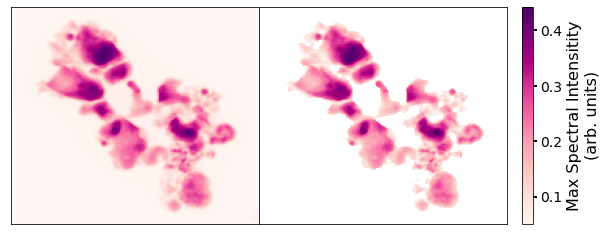

In [8]:
data = Fe_xanes

fig = plt.figure(figsize=(10, 4))
spec = fig.add_gridspec(ncols=2, width_ratios=[0.8, 1.])
plt.subplots_adjust(wspace=0.)

cmap = plt.cm.RdPu
ax = fig.add_subplot(spec[0])
ax.imshow(np.max(data, axis=0), extent=[0, 1, 0, 1], aspect='auto', cmap=cmap)
ax = fig.add_subplot(spec[1])
img = ax.imshow(np.max(get_filtered_img(data), axis=0), extent=[0, 1, 0, 1],
                aspect='auto', cmap=cmap)

for ax in fig.get_axes():
    remove_ticks(ax)

cbar = plt.colorbar(img, ax=ax)
cbar.ax.tick_params(width=2, length=4, labelsize=14)
cbar.ax.set_ylabel('Max Spectral Intensitity\n(arb. units)', fontsize=16)
plt.savefig('Figures/two-dim_heatmap.png', dpi=800,
            transparent=True, bbox_inches='tight')

In [9]:
%matplotlib inline

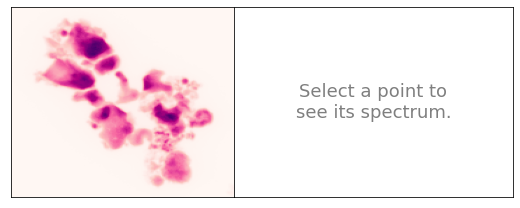

In [10]:
data = Fe_xanes

fig = plt.figure(figsize=(9, 3.5))
spec = fig.add_gridspec(ncols=2, width_ratios=[0.8, 1.])
plt.subplots_adjust(wspace=0.)

ax = fig.add_subplot(spec[0])
img = ax.imshow(np.max(data, axis=0), extent=[0, 1, 0, 1], aspect='auto',
                cmap=plt.cm.RdPu)

ax = fig.add_subplot(spec[1])
ax.text(0.5, 0.5, "Select a point to\nsee its spectrum.", fontsize=18, ha='center', va='center',
        c=plt.cm.tab10(7))

for ax in fig.get_axes():
    remove_ticks(ax)

add_point_label(img, data, ax)

# Step 1. Filter out background, i.e., space with no sample

In [11]:
data = Fe_xanes
energy = Fe_energy

fd, mask = get_filtered_img(data, return_mask=True)

filtered_spectra_dict = {}
for x in range(fd.shape[1]):
    for y in range(fd.shape[2]):
        if mask[0, x, y] == False:
            spectrum = fd[:, x, y]
            filtered_spectra_dict[(x, y)] = spectrum
filtered_spectra = np.array(list(filtered_spectra_dict.values()))

# Step 2. Normalize experimental spectra

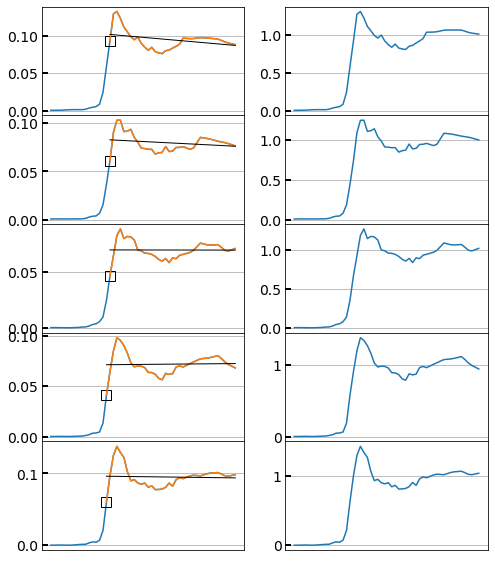

In [12]:
slopes, intercepts, whitelines = show_normalization(energy, filtered_spectra, N=5, return_params=True)

In [13]:
normalized_spectra, normalized_spectra_dict = normalize_spectra(energy,
                                                                filtered_spectra,
                                                                filtered_spectra_dict)

In [14]:
# Renormalize references
Refs, Refs_dict = normalize_spectra(energy, Refs, Refs_dict)
Refs = np.array(Refs)
Refs.shape

(11, 54)

In [15]:
utils = reload(utils)
from utils import *

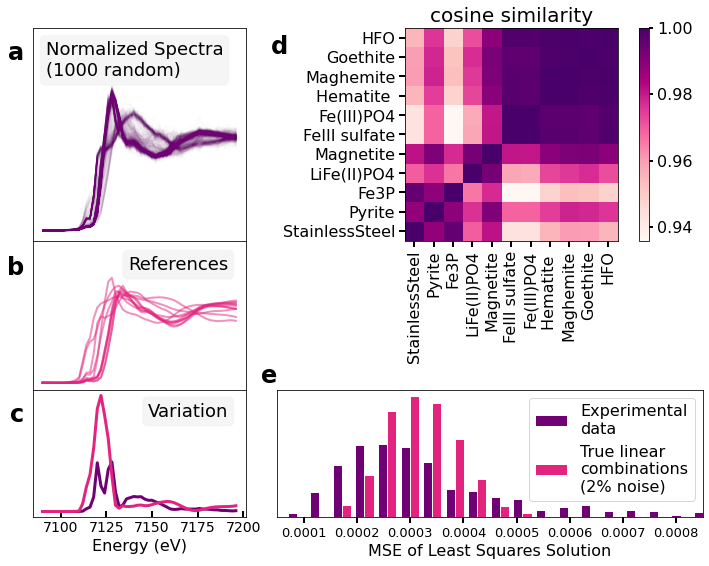

In [249]:
fig = plt.figure(figsize=(12, 9))
spec = fig.add_gridspec(nrows=3, ncols=2,
                        height_ratios=[1, 0.7, 0.6], width_ratios=[0.5, 1])
plt.subplots_adjust(hspace=0., wspace=0.1)
axes = []
for i in range(3):
    tmp = [fig.add_subplot(spec[i, j]) for j in range(2)]
    axes.append(tmp)
    
colors = [plt.cm.RdPu(0.9), plt.cm.PuRd(0.65)]
w = (.95, .95, .95, 0.7)
white_bbox = dict(boxstyle="round", ec=w, fc=w)

c = 0
N = 1000
tmp_X = []
for i in range(len(filtered_spectra)):
    mod = 2
    x = normalized_spectra[mod * i]
    if np.min(x) > -0.01: 
        tmp_X.append(x)
        axes[0][0].plot(energy, normalized_spectra[mod * i], linewidth=1.5, alpha=0.01,
                        color=colors[0])
        c += 1
    if c > N:
        tmp_X = np.array(tmp_X)
        axes[0][0].plot(energy[0], [2.1], '.', c='w', alpha=0)
        break

axes[2][0].plot(energy, np.var(tmp_X, axis=0), linewidth=3, c=colors[0])

for i, r in enumerate(Refs):
    axes[1][0].plot(energy, r, linewidth=2, alpha=0.5, color=colors[1])
axes[1][0].plot(energy[0], [1.85], '.', c='w', alpha=0)

axes[2][0].plot(energy, np.var(Refs, axis=0), linewidth=3, c=colors[1])

labels = [f'Normalized Spectra\n({N} random)', 'References', 'Variation']

panels = ['a', 'b', 'c', 'd', 'e']
for i, ax_list in enumerate(axes):
    for j, ax in enumerate(ax_list):
        if j == 0:
            if i == 0:
                y = 0.94
                ax.text(0.06, y, labels[i], transform=ax.transAxes, fontsize=18, va='top', ha='left',
                        bbox=white_bbox)
            else:
                y = 0.9
                ax.text(0.92, y, labels[i], transform=ax.transAxes, fontsize=18, va='top', ha='right',
                        bbox=white_bbox)
            ax.tick_params(direction='in', width=2, length=6, labelsize=14)
            ax.set_yticks([])
            if i != 2:
                ax.set_xticks([])
            else:
                ax.set_xlabel('Energy (eV)', fontsize=16)
            ax.text(-0.04, y, panels[i], transform=ax.transAxes, fontweight='bold',
                    fontsize=24, va='top', ha='right')
        elif (i, j)  == (0, 1):
            ax.text(-0.55, 0.97, panels[3], transform=ax.transAxes, fontweight='bold',
                    fontsize=24, va='top', ha='right')
        elif (i, j)  == (2, 1):
            ax.text(0.0, 1.2, panels[4], transform=ax.transAxes, fontweight='bold',
                    fontsize=24, va='top', ha='right')

metric = 'cosine similarity'
Similarity_matrix = get_similarity_mtx(Refs, metric=metric)
plot_corr_matx(axes[0][1], Similarity_matrix, data_columns, metric)

axes[1][1].axis('off')
plot_MSE_hist(axes[2][1], tmp_X, Refs, bins=50, colors=colors)
plt.savefig('Figures/Data_vs_Refs.png', dpi=800, bbox_inches='tight', transparent=True)

In [246]:
residuals = []
data = tmp_X
for i in range(len(data)):
    print(i, end='\r')
    A = Refs.T
    y = data[i]
    x = np.linalg.pinv(A.T @ A) @ A.T @ y

    fit = A @ x
    true = y
    residuals.append(A @ x - y)

residuals = np.array(residuals)

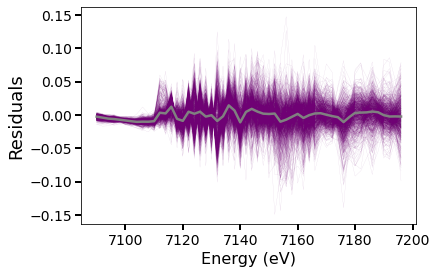

In [247]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.subplots_adjust(wspace=0, hspace=0)
for r in residuals:
    ax.plot(energy, r, color=colors[0], linewidth=0.2, alpha=0.2)

ax.plot(energy, np.average(residuals, axis=0), linewidth=2.5, color='gray')
    
ax.set_xlabel('Energy (eV)', fontsize=16)
ax.set_ylabel('Residuals', fontsize=18)
ax.tick_params(width=2, length=6, labelsize=14)
plt.savefig('Figures/residuals.png', dpi=800, bbox_inches='tight')

# Step 3. Cluster Spectra
# PIPELINE: PCA --> UMAP --> dbscan --> clustering

In [250]:
utils = reload(utils)
from utils import *

1 -> 16
1 -> 12
0 -> 13
0 -> 13
2 -> 18
3 -> 6
3 -> 6
2 -> 19


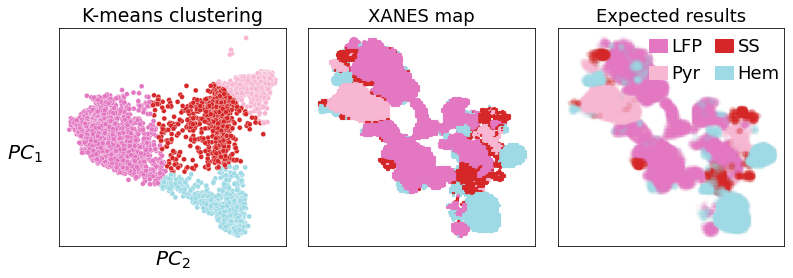

In [251]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(normalized_spectra)

reduced_space = pca_components
spectra_dict = normalized_spectra_dict

clustering = KMeans(n_clusters=4, random_state=42).fit(reduced_space)
cluster_dict = {loc: clustering.labels_[i] for i, loc in enumerate(list(spectra_dict.keys()))}
color_labels, codemap = get_translated_colors(clustering, spectra_dict, map_colors=True,
                                              swap_colors=True)
colors = [plt.cm.tab20(c) for c in color_labels]

fig, axes = plt.subplots(figsize=(13, 4), ncols=3)
plt.subplots_adjust(wspace=0.1)

ax = axes[0]
ax.scatter(reduced_space[:, 0], reduced_space[:, 1], marker='o', s=25, color=colors,
           edgecolor='w', linewidth=0.3)

ax.set_ylabel(f'$PC_1$', fontsize=20, loc="center", rotation="horizontal")
ax.yaxis.set_label_coords(-0.15, 0.37)
ax.set_xlabel(f'$PC_2$', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('K-means clustering', fontsize=19)

plot_color_code_map((fig, axes[1]), normalized_spectra_dict, color_labels)
axes[1].set_title('XANES map', fontsize=18)

plot_expected_results(expected_results, axes[2])
axes[2].set_title('Expected results', fontsize=18)
plt.savefig('Figures/PCA_kmeans_results.png', dpi=800, bbox_inches='tight')

1 -> 16
0 -> 12
4 -> 13
3 -> 13
2 -> 18
3 -> 6
3 -> 6
2 -> 19


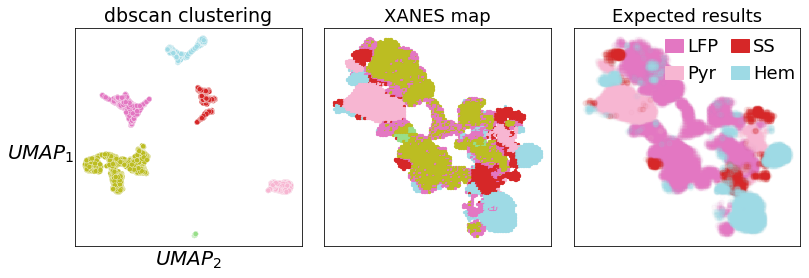

In [255]:
pca = PCA(n_components=6)
pca_components = pca.fit_transform(normalized_spectra)
spectra_dict = normalized_spectra_dict

reducer = umap.UMAP(random_state=42, n_components=2,
                    n_neighbors=80, min_dist=0)
reduced_space = reducer.fit_transform(pca_components)

eps = 1
clustering = DBSCAN(eps=eps, min_samples=1).fit(reduced_space)
cluster_dict = {loc: clustering.labels_[i] for i, loc in enumerate(list(spectra_dict.keys()))}
color_labels, codemap = get_translated_colors(clustering, spectra_dict, map_colors=True,
                                              swap_colors=True)
colors = [plt.cm.tab20(c) for c in color_labels]

fig, axes = plt.subplots(figsize=(13, 4), ncols=3)
plt.subplots_adjust(wspace=0.1)

ax = axes[0]
ax.scatter(reduced_space[:, 0], reduced_space[:, 1], marker='o', s=25, color=colors,
           edgecolor='w', linewidth=0.3)

ax.set_ylabel(f'$UMAP_1$', fontsize=20, loc="center", rotation="horizontal")
ax.yaxis.set_label_coords(-0.15, 0.37)
ax.set_xlabel(f'$UMAP_2$', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('dbscan clustering', fontsize=19)

plot_color_code_map((fig, axes[1]), normalized_spectra_dict, color_labels)
axes[1].set_title('XANES map', fontsize=18)

plot_expected_results(expected_results, axes[2])
axes[2].set_title('Expected results', fontsize=18)

plt.savefig('Figures/UMAP_2D_results.png', dpi=800, bbox_inches='tight')

In [256]:
print(len(np.unique(clustering.labels_)), len(np.unique(color_labels)))

6 6


It takes 8 PCs to explain 97% variance.


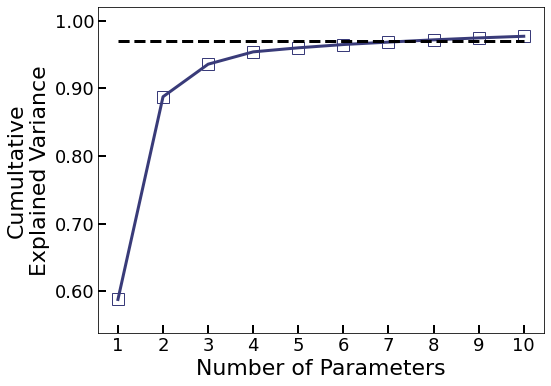

In [257]:
n_components = make_scree_plot(normalized_spectra, n=10, c=0, threshold=0.97, show_first_PC=False)

It takes 8 PCs to explain 97% variance.
1 -> 12
0 -> 7
5 -> 13
4 -> 1
2 -> 18
3 -> 6
4 -> 0
2 -> 19


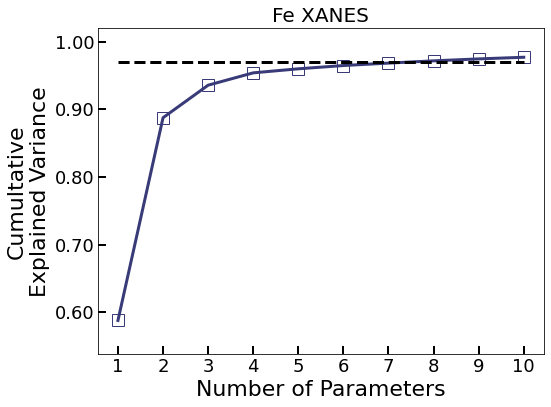

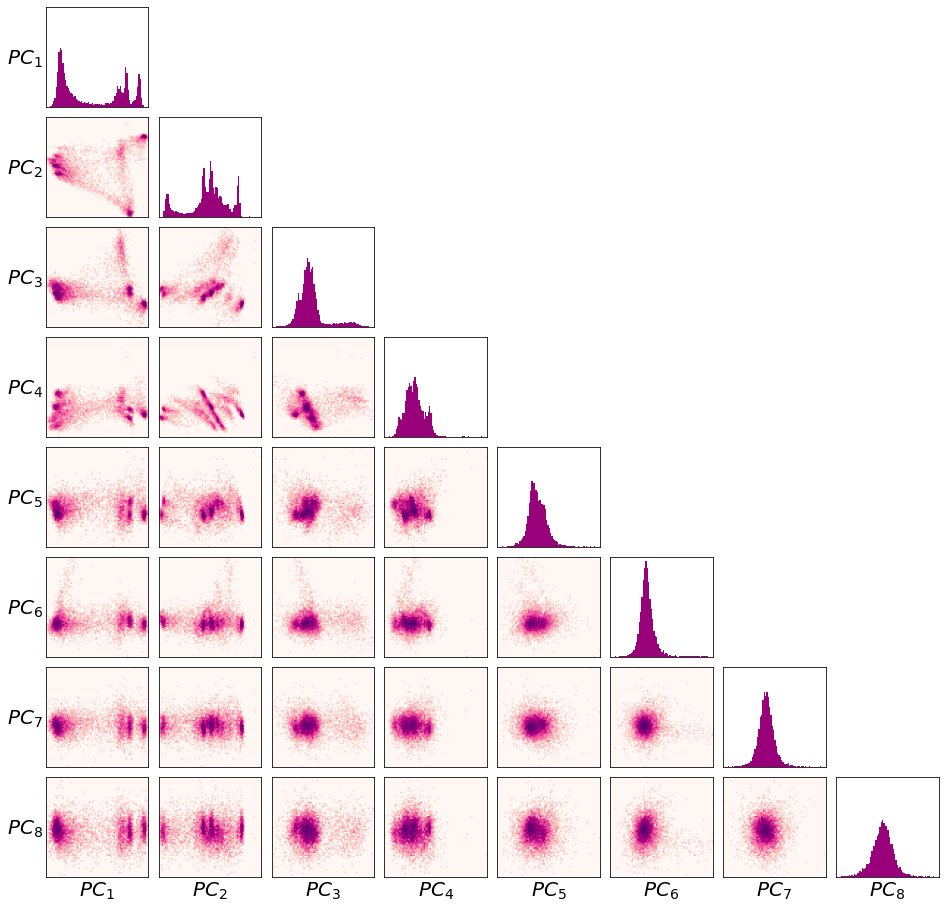

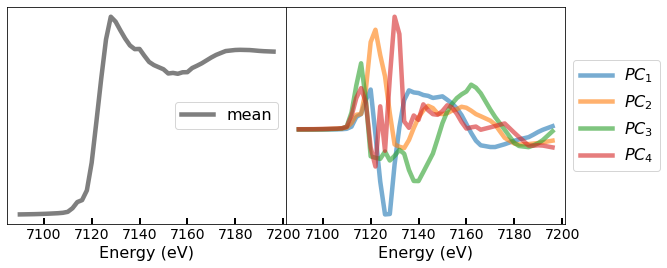

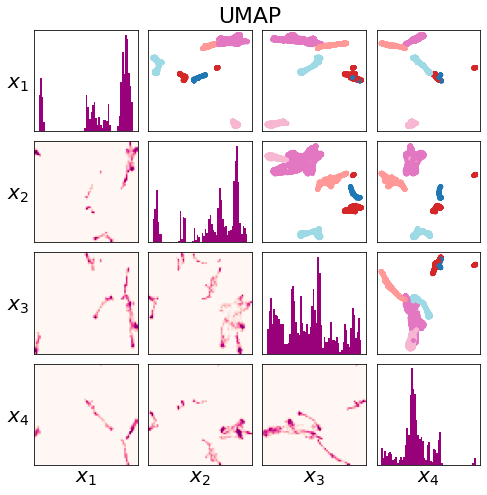

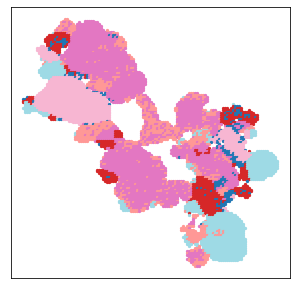

In [273]:
# PCA
n_components = make_scree_plot(normalized_spectra, n=10, c=0, threshold=0.97, show_first_PC=False)
plt.title('Fe XANES', fontsize=20)
plt.savefig('Figures/full_spectra_scree.png', dpi=800, bbox_inches='tight')

pca, pca_components = make_PCA_triangle_plot(normalized_spectra, n_components, bins=70,
                                             cmap=plt.cm.RdPu, c=plt.cm.RdPu(0.8))
plt.savefig('Figures/full_spectra_PCA_traingle_plot.png', dpi=600, bbox_inches='tight')

show_PCs(energy, pca, n=4)
plt.savefig('Figures/full_spectra_first_PCs.png', dpi=800, bbox_inches='tight')

# UMAP & dbscan
color_labels, codemap, dbscan_clustering = make_UMAP_plot(pca_components, normalized_spectra_dict, eps=1.0,
                                                          n_neighbors=30, min_dist=0, dimension=4, bins=60,
                                                          cmap=plt.cm.RdPu, c=plt.cm.RdPu(0.8))
plt.savefig('Figures/full_spectra_UMAP.png', dpi=800, bbox_inches='tight')

# Final clusters
plot_color_code_map(plt.subplots(figsize=(5, 5)), normalized_spectra_dict, color_labels)
plt.savefig('Figures/full_spectra_cluster_map.png', dpi=800, bbox_inches='tight')

In [274]:
print(len(np.unique(dbscan_clustering.labels_)), len(np.unique(color_labels)))

7 6


# Step 4. LCF

### First find cluster averages

In [275]:
exp_data = np.array(normalized_spectra)
indices = np.arange(len(exp_data))
n_reps = 5000
sims = []
for i in range(n_reps):
    rand_idxs = np.random.choice(indices, size=2, replace=False)
    similarity = evaluate_similarity(exp_data[rand_idxs[0]],
                                     exp_data[rand_idxs[1]], metric)
    sims.append(similarity)
sims = np.array(sims)
print(np.average(sims), np.std(sims))

0.9869376905943135 0.010453870693663768


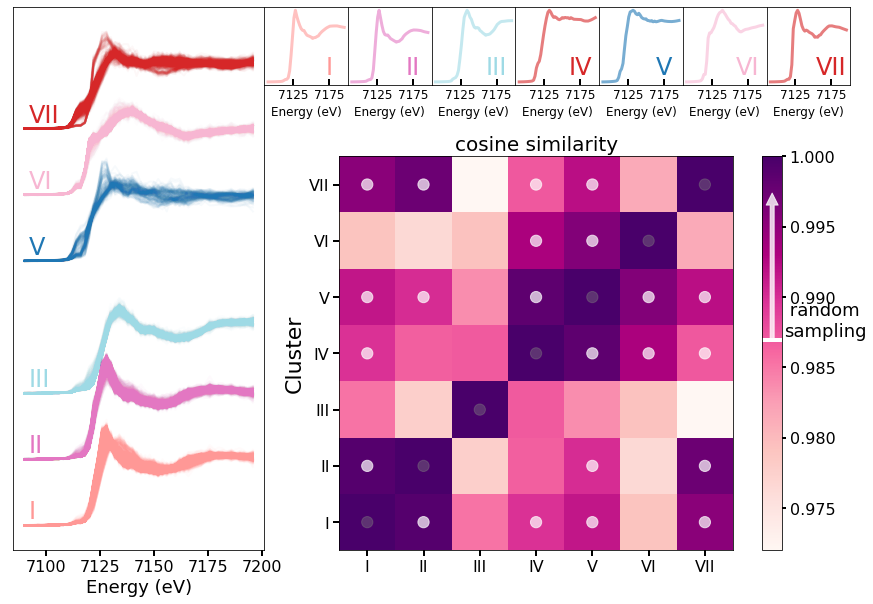

In [277]:
cluster_avgs = get_cluster_avgs(normalized_spectra_dict, color_labels, dbscan_clustering)
avg_spectra = np.array(list(cluster_avgs.values()))
n_clusters = len(avg_spectra)
labels = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII']

fig = plt.figure(figsize=(15, 10))
width_ratios = np.ones(1 + n_clusters)
width_ratios[1:] = width_ratios[1:] / 3

spec = fig.add_gridspec(nrows=2, ncols=1 + n_clusters,
                        height_ratios=[0.2, 1.], width_ratios=width_ratios)
plt.subplots_adjust(hspace=0.3, wspace=0.)
subplts = [fig.add_subplot(spec[:, 0]), fig.add_subplot(spec[1, 1:])]
axes = [fig.add_subplot(spec[0, 1 + i]) for i in range(n_clusters)]
   
plot_spaghetti_by_cluster(subplts[0], energy, normalized_spectra, avg_spectra,
                          color_labels, labels, codemap)
plot_cluster_avgs((fig, axes), energy, cluster_avgs, codemap, linewidth=3)

metric = 'cosine similarity'
sim_matrix = get_similarity_mtx(avg_spectra, metric=metric)
plot_corr_matx(subplts[1], sim_matrix, labels, metric, rot=0,
               threshold=np.average(sims), std=np.std(sims))
subplts[1].set_ylabel('Cluster', fontsize=22)

plt.savefig('Figures/full_spectra_cluster_averages.png', dpi=800, bbox_inches='tight')

## How reliable are Refs fitted onto themselves?

It takes 3 PCs to explain 95% variance.


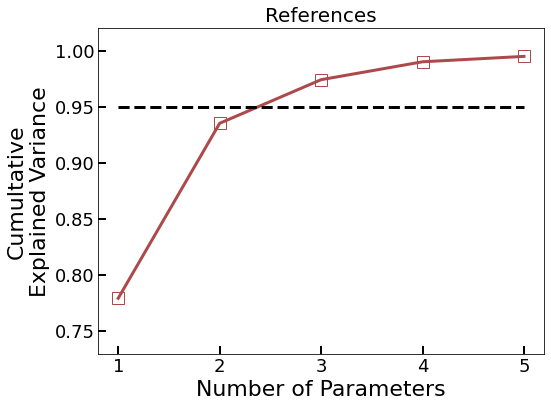

In [263]:
make_scree_plot(Refs, threshold=.98, show_first_PC=False, c=13)
plt.title('References', fontsize=20)
plt.savefig('Figures/refs_scree.png', dpi=800, bbox_inches='tight')

In [278]:
subset_size = 6
subset_indices, subsets, scales, coeffs, scores = [], [], [], [], []
targets = Refs 
for i in range(len(targets)):
    sub_idxs, subset, scale, coeffs_hat, score = LCF(targets[i], targets, subset_size,
                                                     lambda1=0.1, lambda2=1e8)
    subset_indices.append(sub_idxs)
    subsets.append(subset)
    coeffs.append(coeffs_hat)
    scales.append(scale)
    scores.append(score)

[ 0  3  6  7  9 10] 2.973182867878704e-05
[0 1 2 4 5 6] 9.929374708150197e-06
[0 1 2 6 7 9] 2.204816525045273e-06
[0 2 3 4 6 9] 3.388962983765981e-06
[0 2 4 6 7 8] 3.003152451805814e-06
[ 0  1  2  3  5 10] 1.1050600913107078e-07
[0 1 2 3 6 8] 7.078190846907789e-07
[0 2 3 4 7 9] 2.4661175899774103e-08
[1 4 5 6 7 8] 0.0008188632391308239
[0 1 2 3 4 9] 1.705295972699231e-07
[ 1  4  6  7  8 10] 0.00013013268896616486


Maghemite


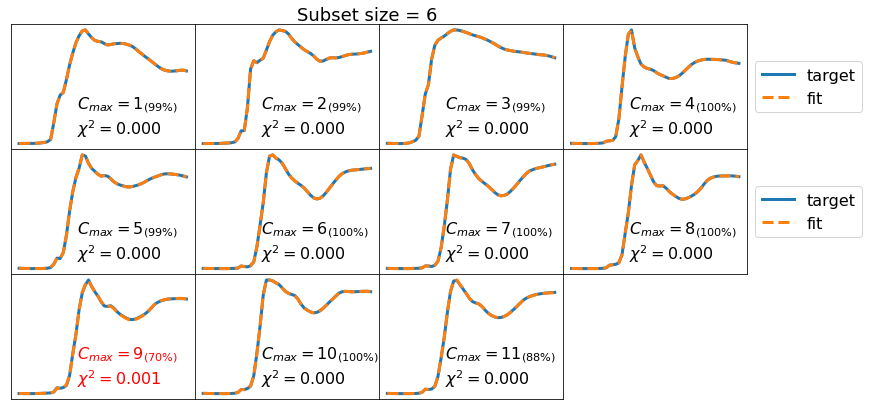

In [279]:
plot_recon_grid(energy, targets, subset_indices, subsets, scales, coeffs, Refs_dict,
                verbose=True, ncols=4, c=1)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.show()

## Cluster averages fit to Refs

In [267]:
subset_size = 4
subset_indices, subsets, scales, coeffs, scores = [], [], [], [], []
targets = np.array(list(cluster_avgs.values()))
for i in range(len(targets)):
    sub_idxs, subset, scale, coeffs_hat, score = LCF(targets[i], Refs, subset_size,
                                                     lambda1=0.1, lambda2=1e8)
    subset_indices.append(sub_idxs)
    subsets.append(subset)
    scales.append(scale)
    coeffs.append(coeffs_hat)
    scores.append(score)

[1 2 3 7] 0.021325170365065083
[ 2  6  7 10] 0.004630666857510895
[ 0  2  3 10] 0.0653079907243435
[0 1 6 7] 0.005661096565188754
[ 0  1  3 10] 0.0981106859009908


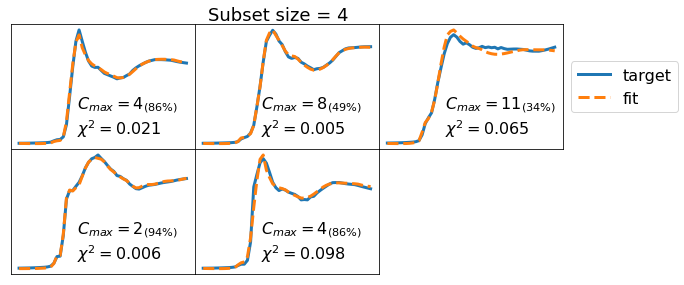

In [268]:
plot_recon_grid(energy, targets, subset_indices, subsets, scales, coeffs, Refs_dict,
                ncols=3, flag_identity=False, c=1)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.show()

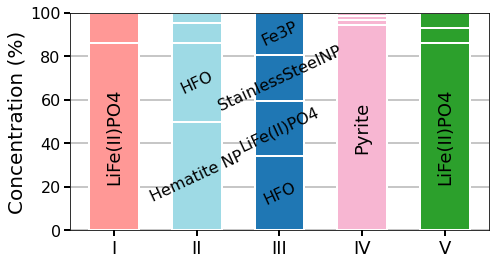

In [269]:
fig, ax = plt.subplots(figsize=(len(cluster_avgs) * 1.5, 4))
plot_conc_from_subset((fig, ax), np.array(coeffs).reshape(len(coeffs), -1),
                      list(Refs_dict.keys()), subset_indices, codemap)
plt.savefig('Figures/full_spectra_cluster_concentrations.png', dpi=800, bbox_inches='tight')

In [270]:
utils = reload(utils)
from utils import *

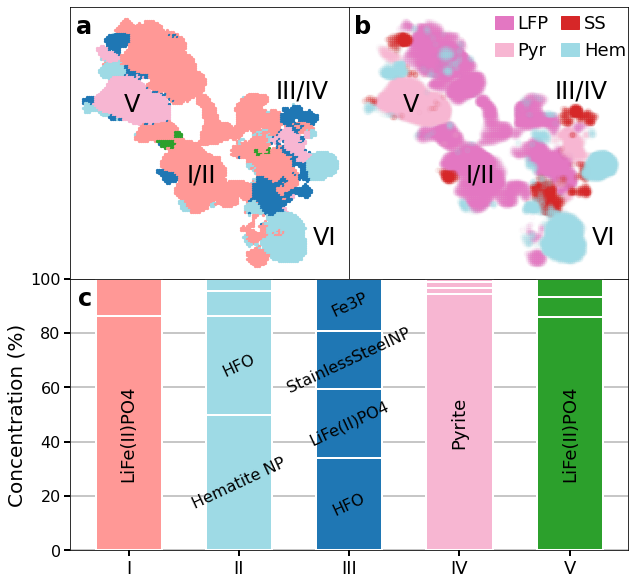

In [272]:
fig = plt.figure(figsize=(10, 10))
spec = fig.add_gridspec(nrows=2, ncols=2)
axes = [fig.add_subplot(spec[0, 0]), fig.add_subplot(spec[0, 1]),
        fig.add_subplot(spec[1, :])]
plt.subplots_adjust(hspace=0.0, wspace=0.0)

plot_color_code_map((fig, axes[0]), normalized_spectra_dict, color_labels)

plot_expected_results(expected_results, axes[1])

plot_conc_from_subset((fig, axes[2]), np.array(coeffs).reshape(len(coeffs), -1),
                      list(Refs_dict.keys()), subset_indices, codemap)

panels = ['a', 'b', 'c']
for i, ax in enumerate(axes):
    if i == 2:
        x = 0.03
    else:
        x = 0.08
    ax.text(x, 0.97, panels[i], transform=ax.transAxes, fontweight='bold',
            fontsize=24, va='top', ha='right')
    
points = [(0.22, 0.64), (0.47, 0.38), (0.91, 0.15), (0.83, 0.69)]
labels = ['V', 'I/II', 'VI', 'III/IV']
for ax in axes[:2]:
    for i, pt in enumerate(points):
        x, y = pt
        ax.text(x, y, labels[i], transform=ax.transAxes,
                fontsize=24, va='center', ha='center')

plt.savefig('Figures/full_spectrum_results.png', dpi=800,
            transparent=True, bbox_inches='tight')

# PART II. Recursive Feature Elimination

In [245]:
energy_point_selector = reload(selector.energy_point_selector)

In [247]:
N = 3
x = np.linspace(0, 8, 50)
mus = np.linspace(2, 5, N)
sigmas = np.array([mu / 5 for mu in mus])

def normal(x, mu, sig):
    return ( 1 / sig * np.sqrt(2 * np.pi) ) * np.exp( -0.5 * ((x - mu) / sig)**2 )

basis = np.array([normal(x, mus[i], sigmas[i]) for i in range(len(mus))])
basis.shape

(3, 50)

In [279]:
utils = reload(utils)
from utils import *

n = 1
n = 2
n = 3
n = 4


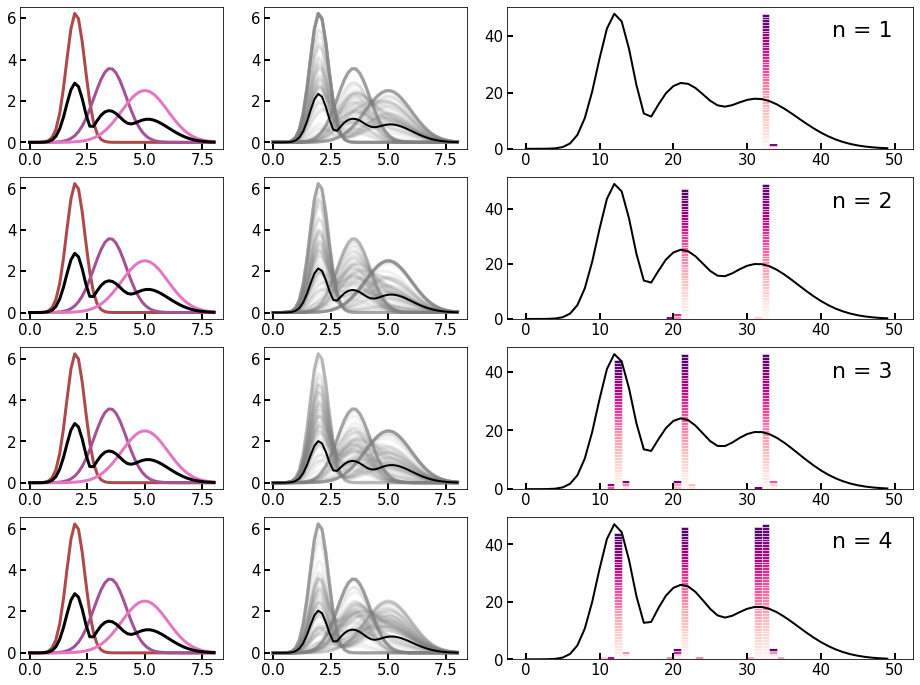

In [281]:
best_estimator = 'Linear Regression'
kwargs = {'N': 100, 'scale': 0.0, 'dropout': 0.4}
reps = 50
colors = [plt.cm.tab20b(13), plt.cm.tab20b(17), plt.cm.tab20(12)]

Ns = np.arange(1, 5)

fig = plt.figure(figsize=(16, 3 * len(Ns)))
spec = fig.add_gridspec(ncols=3, nrows=len(Ns), width_ratios=[0.5, 0.5, 1.0])
plt.subplots_adjust(wspace=0.15, hspace=0.2)

for row, best_n in enumerate(Ns):
    print(f'n = {best_n}')
    Is = []
    for rep in range(reps):
        print(rep, end='\r')
        data, coeffs = generate_linear_combos(basis, **kwargs)

        select = energy_point_selector.Selector(data, coeffs)
        rfe = select.select_energy_points(estimator=best_estimator, n_points=best_n,
                                          verbose=False, scoring='neg_root_mean_squared_error')
        energy_measurements = x[rfe.support_]
        indices = [i for i, e in enumerate(x) if e in energy_measurements]
        Is.append(indices)
    Is = np.array(Is)
    
    indices = []
    
    axes = [fig.add_subplot(spec[row, j]) for j in range(3)]
    plot_RFE_results(axes, x, basis, indices, Is, best_n, colors, leg=False, **kwargs)
    
plt.savefig('Figures/test_RFE_results.png', dpi=600, bbox_inches='tight')

## RFE on the Reference Set

In [343]:
best_estimator = 'Linear Regression'
best_n = 20
Is = []

reps = 100
for i in range(reps):
    print(i, end='\r')
    kwargs = {'N': 100, 'scale': 0.0, 'dropout': 0.85}
    data, coeffs = generate_linear_combos(Refs, **kwargs)
    
    select = energy_point_selector.Selector(data, coeffs)
    rfe = select.select_energy_points(estimator=best_estimator, n_points=best_n,
                                      verbose=False, scoring='neg_root_mean_squared_error')
    energy_measurements = energy[rfe.support_]
    indices = [i for i, e in enumerate(energy) if e in energy_measurements]
    Is.append(indices)
Is = np.array(Is)

In [373]:
utils = reload(utils)
from utils import *

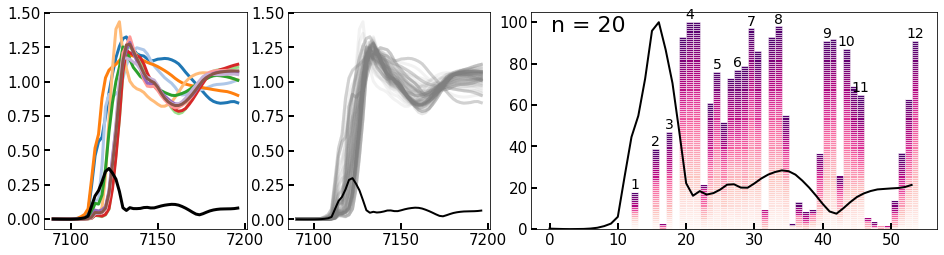

In [346]:
fig = plt.figure(figsize=(16, 4))
spec = fig.add_gridspec(ncols=3, width_ratios=[0.5, 0.5, 1.0])
plt.subplots_adjust(wspace=0.15)
axes = [fig.add_subplot(spec[j]) for j in range(3)]

indices = [12, 15, 17, 20, 24, 27, 29, 33, 40, 43, 45, 53]
colors = [plt.cm.tab20(i) for i in range(len(Refs))]
plot_RFE_results(axes, energy, Refs, indices, Is, best_n, colors,
                 leg=False, loc=2, **kwargs)

plt.savefig('Figures/RFE_results_Refs.png', dpi=600, bbox_inches='tight')

# RFE on a random sampling of experimental spectra

In [371]:
basis = np.array([x for i, x in enumerate(normalized_spectra) if i % 200 == 0])
print(basis.shape)

(34, 54)


In [372]:
best_estimator = 'Linear Regression'
best_n = 30
Is = []
kwargs = {'N': 2000, 'scale': 0.0, 'dropout': 0.985}

reps = 50
for i in range(reps):
    print(i, end='\r')
    data, coeffs = generate_linear_combos(basis, **kwargs)
    
    select = energy_point_selector.Selector(data, coeffs)
    rfe = select.select_energy_points(estimator=best_estimator, n_points=best_n,
                                      verbose=False, scoring='neg_root_mean_squared_error')
    energy_measurements = energy[rfe.support_]
    indices = [i for i, e in enumerate(energy) if e in energy_measurements]
    Is.append(indices)
Is = np.array(Is)

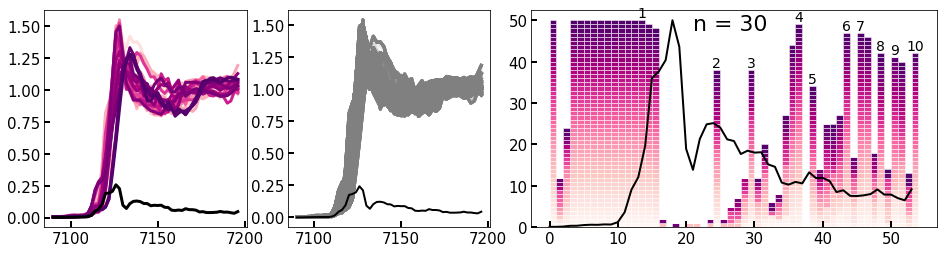

In [375]:
fig = plt.figure(figsize=(16, 4))
spec = fig.add_gridspec(ncols=3, width_ratios=[0.5, 0.5, 1.0])
plt.subplots_adjust(wspace=0.15)
axes = [fig.add_subplot(spec[j]) for j in range(3)]

indices = [12, 24, 29, 36, 38, 43, 45, 48, 50, 53]
colors = [plt.cm.RdPu(i / len(basis)) for i in range(len(basis))]
plot_RFE_results(axes, energy, basis, indices, Is, best_n, colors,
                 leg=False, loc=3, **kwargs)

plt.savefig('Figures/RFE_results_rand_sample_exp_data.png', dpi=600, bbox_inches='tight')

# Back to the pipeline on energy subset
## Step 1. Slice energies

In [376]:
#indices = [0, 4, 7, 11, 16, 20, 27, 29, 34, 38, 42, 52]
indices = [12, 15, 17, 20, 24, 27, 29, 33, 40, 43, 45, 53]
# indices_exp = [12, 24, 29, 36, 38, 43, 45, 48, 50, 53]
# same_indices = [12, 24, 29, 43, 45, 53]
energy_subset = np.array(energy[indices])
Y_Refs = Refs[:, indices]

prenormalized_subset = np.array(normalized_spectra)[:, indices]

data_subset = np.array(filtered_spectra)[:, indices]
postnormalized_subset, postnormalized_subset_dict = normalize_spectra(energy_subset,
                                                                      data_subset,
                                                                      filtered_spectra_dict)

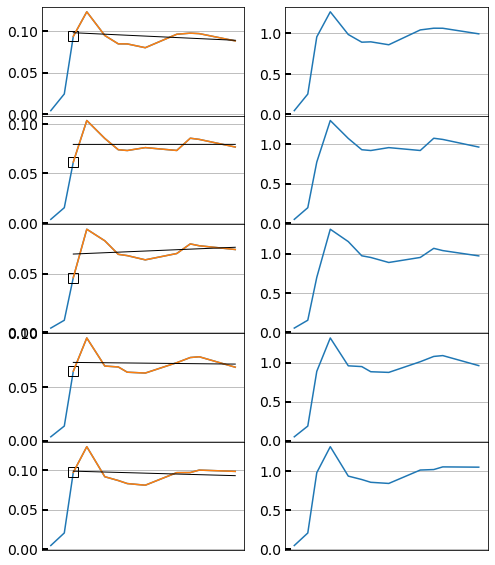

In [377]:
sub_slopes, sub_intercepts, sub_whitelines = show_normalization(energy_subset, data_subset,
                                                                N=5, return_params=True)

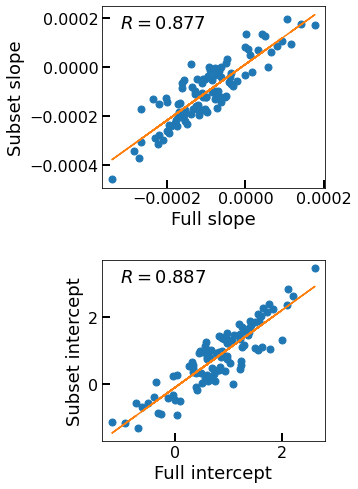

In [378]:
N = 100
slopes, intercepts, whitelines = show_normalization(energy, filtered_spectra,
                                                    N=N, return_params=True, plot=False)
sub_slopes, sub_intercepts, sub_whitelines = show_normalization(energy_subset, data_subset,
                                                                N=N, return_params=True, plot=False)

fig, axes = plt.subplots(figsize=(4, 8), nrows=2)
plt.subplots_adjust(hspace=0.4)

def plot_corr(x1, x2, ax):
    ax.plot(x1, x2, 'o', markersize=7)

    reg = LinearRegression().fit(x1.reshape(-1, 1), x2.reshape(-1, 1))
    y_fit = reg.predict(x1.reshape(-1, 1)).reshape(-1)
    ax.plot(x1, y_fit, '-')

    x = np.linspace(min(x1), max(x1), 10)
    #ax.plot(x, x, '--', c='k')
    
    R, pval = pearsonr(x1, x2)
    ax.text(0.08, 0.88, f'$R={R:.3f}$', transform=ax.transAxes, fontsize=18)

plot_corr(slopes, sub_slopes, axes[0])
plot_corr(intercepts, sub_intercepts, axes[1])

variables = ['slope', 'intercept']
for i, ax in enumerate(axes):
    ax.set_ylabel(f'Subset {variables[i]}', fontsize=18)
    ax.set_xlabel(f'Full {variables[i]}', fontsize=18)
    ax.tick_params(direction='in', width=2, length=8, labelsize=16)

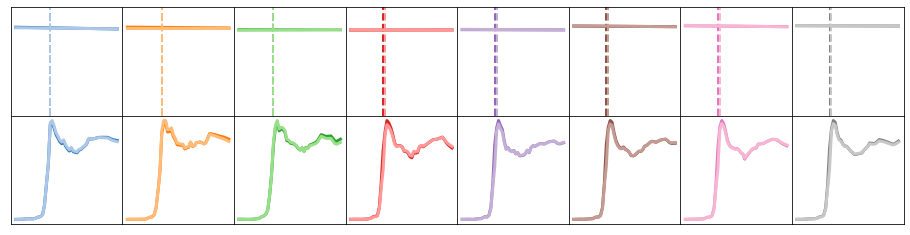

In [379]:
N = 8
plot_recon = True

slopes, intercepts, whitelines = show_normalization(energy, filtered_spectra,
                                                    N=N, return_params=True, plot=False)
sub_slopes, sub_intercepts, sub_whitelines = show_normalization(energy_subset, data_subset,
                                                                N=N, return_params=True, plot=False)

if plot_recon:
    fig, axes = plt.subplots(figsize=(2 * N, 4), ncols=N, nrows=2)
    plt.subplots_adjust(wspace=0, hspace=0)

MSEs = []
for idx in range(N):
    xs = []
    for j, params in enumerate([[slopes[idx], intercepts[idx], whitelines[idx]],
                                [sub_slopes[idx], sub_intercepts[idx], sub_whitelines[idx]]]):
        m, b, w = params
        y_fit = m * energy + b
        
        spectrum = filtered_spectra[idx + 50]
        if j == 0:
            whiteline = w + 1
        else:
            whiteline = indices[w] + 1
        
        y_norm = spectrum.copy()
        offset = y_fit.reshape(-1)[whiteline:]
        y_norm[whiteline:] = y_norm[whiteline:] - offset + spectrum[whiteline + 1]
        y_norm = y_norm / (spectrum[whiteline + 1])
        xs.append(y_norm)
        
        if plot_recon:
            axes[0, idx].plot(energy, y_fit + 1,
                              c=plt.cm.tab20(2 * idx + j), linewidth=3)

            axes[0, idx].axvline(energy[whiteline], linestyle='--', c=plt.cm.tab20(2 * idx + j),
                                 linewidth=2)
            axes[0, idx].set_ylim(min(y_norm), max(y_norm) + 0.1)

            axes[1, idx].plot(energy, y_norm, linestyle='-', c=plt.cm.tab20(2 * idx + j),
                              linewidth=3)
    if plot_recon:
        for ax in axes[:, idx]:
            ax.set_yticks([])
            ax.set_xticks([])
            
    MSEs.append(mean_squared_error(xs[0], xs[1]))
    
if plot_recon == False:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(MSEs, edgecolor='w', bins=50)
    ax.tick_params(direction='in', width=2, length=8, labelsize=14)
    ax.set_xlabel('MSE', fontsize=16)

## Step 2. Clustering pipeline

It takes 7 PCs to explain 99% variance.
1 -> 12
1 -> 7
5 -> 13
5 -> 1
2 -> 18
3 -> 6
1 -> 0
2 -> 19


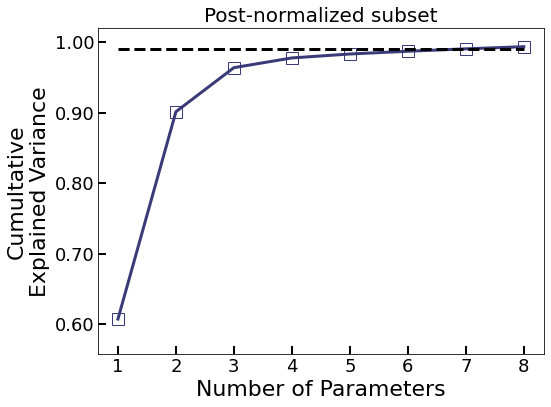

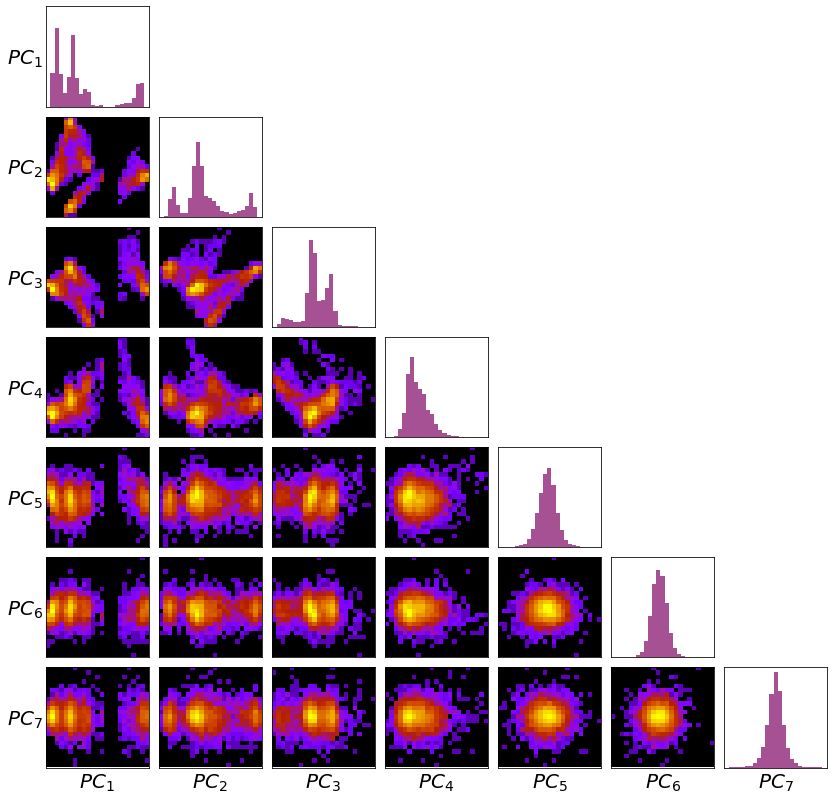

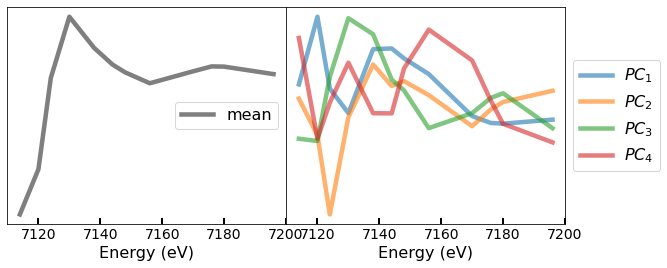

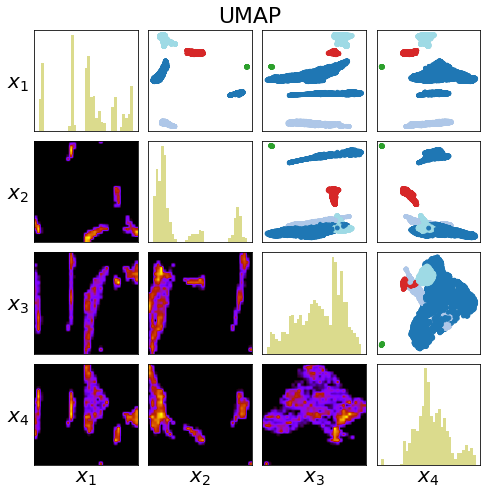

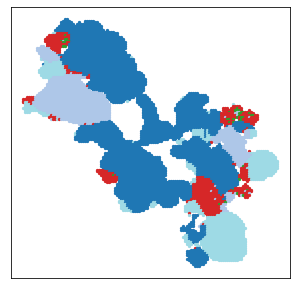

In [381]:
# PCA
n_components_sub = make_scree_plot(postnormalized_subset, n=8, c=0, threshold=0.99, show_first_PC=False)
plt.title('Post-normalized subset', fontsize=20)
plt.savefig('Figures/subset_scree.png', dpi=600, bbox_inches='tight')

pca, pca_components = make_PCA_triangle_plot(postnormalized_subset, n_components_sub, bins=70
                                             cmap=plt.cm.RdPu, c=plt.cm.RdPu(0.8))
plt.savefig('Figures/subset_PCA_traingle_plot.png', dpi=600, bbox_inches='tight')

show_PCs(energy_subset, pca, n=4)
plt.savefig('Figures/subset_first_PCs.png', dpi=600, bbox_inches='tight')

# UMAP
color_labels_sub, codemap_sub, dbscan_clustering_sub = make_UMAP_plot(pca_components, normalized_spectra_dict,
                                                                      n_neighbors=10, min_dist=0, dimension=4,
                                                                      eps=1., bins=60,
                                                                      cmap=plt.cm.RdPu, c=plt.cm.RdPu(0.8))
plt.savefig('Figures/subset_UMAP.png', dpi=600, bbox_inches='tight')

# Final Clusters
plot_color_code_map(plt.subplots(figsize=(5, 5)), normalized_spectra_dict, color_labels_sub)
plt.savefig('Figures/subset_cluster_map.png', dpi=600, bbox_inches='tight')

In [382]:
print(len(np.unique(dbscan_clustering_sub.labels_)))
print(len(np.unique(color_labels_sub)))

6
5


## Step 3. LCF

In [383]:
clusters = {i: [] for i in np.unique(dbscan_clustering_sub.labels_)}

for i, key in enumerate(list(normalized_spectra_dict.keys())):
    spectrum = normalized_spectra_dict[key][indices]
    color = dbscan_clustering_sub.labels_[i]
    clusters[color].append(spectrum)

cluster_avgs = {key: np.average(clusters[key], axis=0) for key in list(clusters.keys())}

In [384]:
subset_size = 4 
subset_indices_sub, subsets_sub, scales_sub, coeffs_sub, scores_sub = [], [], [], [], []
targets = np.array(list(cluster_avgs.values()))
for i in range(len(targets)):
    sub_idxs, subset, scale, coeffs_hat, score = LCF(targets[i], Y_Refs, subset_size,
                                                     lambda1=0.1, lambda2=1e8)
    subset_indices_sub.append(sub_idxs)
    subsets_sub.append(subset)
    scales_sub.append(scale)
    coeffs_sub.append(coeffs_hat)
    scores_sub.append(score)

[0 1 3 7] 0.015150288306527067
[0 1 3 9] 0.0046139238232034115
[2 3 5 7] 0.005346156095354191
[1 3 8 9] 0.0818565864234611
[1 3 7 9] 0.11880855665092933
[1 3 4 5] 0.020105617202842013


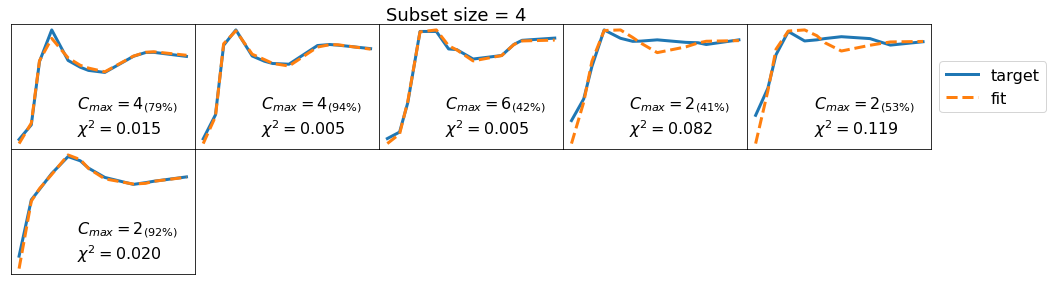

In [385]:
plot_recon_grid(energy_subset, targets, subset_indices_sub, subsets_sub, scales_sub, coeffs_sub, Refs_dict,
                ncols=5, flag_identity=False, c=1)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.show()

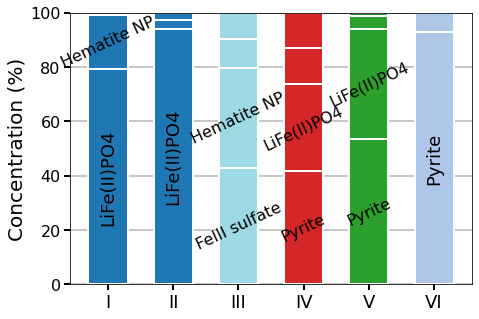

In [386]:
fig, ax = plt.subplots(figsize=(len(cluster_avgs) * 1.2, 5))
plot_conc_from_subset((fig, ax), np.array(coeffs_sub).reshape(len(coeffs_sub), -1),
                      list(Refs_dict.keys()), subset_indices_sub, codemap_sub)
plt.savefig('Figures/subset_cluster_concentrations.png', dpi=600, bbox_inches='tight')

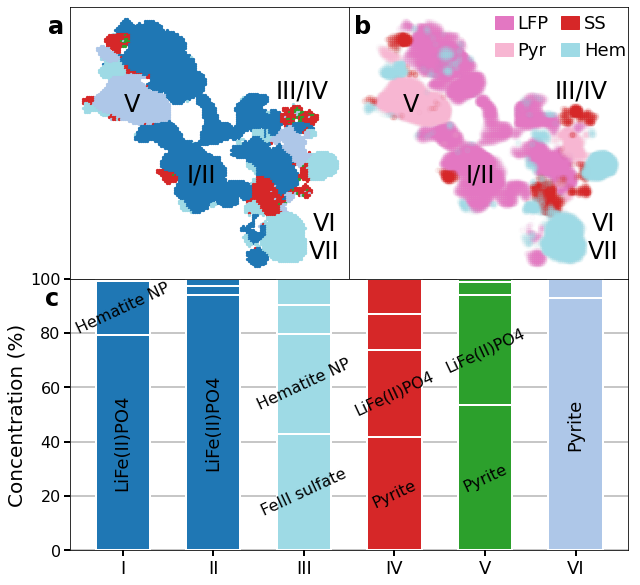

In [387]:
fig = plt.figure(figsize=(10, 10))
spec = fig.add_gridspec(nrows=2, ncols=2)
axes = [fig.add_subplot(spec[0, 0]), fig.add_subplot(spec[0, 1]),
        fig.add_subplot(spec[1, :])]
plt.subplots_adjust(hspace=0.0, wspace=0.0)

plot_color_code_map((fig, axes[0]), normalized_spectra_dict, color_labels_sub)

plot_expected_results(expected_results, axes[1])

plot_conc_from_subset((fig, axes[2]), np.array(coeffs_sub).reshape(len(coeffs_sub), -1),
                      list(Refs_dict.keys()), subset_indices_sub, codemap_sub)

panels = ['a', 'b', 'c']
for i, ax in enumerate(axes):
    if i in [0, 2]:
        x = -0.02
    else:
        x = 0.08
    ax.text(x, 0.97, panels[i], transform=ax.transAxes, fontweight='bold',
            fontsize=24, va='top', ha='right')
    
points = [(0.22, 0.64), (0.47, 0.38), (0.91, 0.15), (0.83, 0.69)]
labels = ['V', 'I/II', 'VI\nVII', 'III/IV']
for ax in axes[:2]:
    for i, pt in enumerate(points):
        x, y = pt
        ax.text(x, y, labels[i], transform=ax.transAxes,
                fontsize=24, va='center', ha='center')

plt.savefig('Figures/subset_results.png', dpi=600,
            transparent=True, bbox_inches='tight')

# Comparing both analyses

In [ ]:
def get_cluster_conc(i, dbscan_clustering, subset_indices, N, coeffs):
    cluster = dbscan_clustering.labels_[i]
    concentrations = np.zeros(N)
    for j, index in enumerate(subset_indices[cluster]):
        concentrations[index] = coeffs[cluster, 0, j]
    return concentrations

In [ ]:
scores = []
X1 = []
X2 = []
for i in range(len(normalized_spectra)):
    x1 = get_cluster_conc(i, dbscan_clustering, np.array(subset_indices),
                          Refs.shape[0], np.array(coeffs))
    x2 = get_cluster_conc(i, dbscan_clustering_sub, np.array(subset_indices_sub),
                          Y_Refs.shape[0], np.array(coeffs_sub))
    score = wasserstein_distance(x1, x2)
    scores.append(score)
    X1.append(x1)
    X2.append(x2)
scores = np.array(scores)
X1 = np.array(X1)
X2 = np.array(X2)
print(np.average(scores))

In [ ]:
spectra_dict = normalized_spectra_dict
colors = [s / np.max(scores) + np.min(scores) for s in scores]
norm = mpl.colors.Normalize(vmin=np.min(scores), vmax=np.max(scores))

"""
intensities = np.max(filtered_spectra, axis=1)
norm = mpl.colors.Normalize(vmin=np.min(intensities), vmax=np.max(intensities))
intensities = [c / np.max(intensities) + np.min(intensities) for c in intensities]
intensities = np.array(intensities)
colors = intensities
"""

fig, ax = plt.subplots(figsize=(6, 5))
for i, key in enumerate(list(spectra_dict.keys())):
    spectrum = spectra_dict[key]
    x, y = key
    ax.plot(y, -x, marker='.', color=plt.cm.viridis(colors[i]), markersize=4.5)
remove_ticks(ax) 

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis))
cbar.ax.tick_params(direction='out', width=2, length=6, labelsize=14)
plt.show()

# Analysis within clusters -- does LCF accuracy improve when filtering out for each cluster?

In [ ]:
utils = reload(utils)
from utils import *

In [ ]:
plot_color_code_map(normalized_spectra_dict, color_labels_sub, show_cluster=19)

In [ ]:
select_cluster = 19

sub_cluster_data = []
for i, key in enumerate(list(normalized_spectra_dict.keys())):
    spectrum = normalized_spectra_dict[key][indices]
    label = color_labels_sub[i]
    if label == select_cluster:
        sub_cluster_data.append(spectrum)
sub_cluster_data = np.array(sub_cluster_data)
print(sub_cluster_data.shape)

In [ ]:
subset_size = 3
subset_indices_sub, subsets_sub, scales_sub, coeffs_sub, scores_sub = [], [], [], [], []
targets = sub_cluster_data
for i in range(len(targets)):
    sub_idxs, subset, scale, coeffs_hat, score = LCF(targets[i], Y_Refs, subset_size,
                                                     lambda1=0.1, lambda2=1e8, verbose=False)
    subset_indices_sub.append(sub_idxs)
    subsets_sub.append(subset)
    scales_sub.append(scale)
    coeffs_sub.append(coeffs_hat)
    scores_sub.append(score)
    print(f'       {i}', end='\r')
    #if i == 100:
    #    break

In [ ]:
labels = np.max(np.array(subset_indices_sub), axis=1)
unique_labels = np.unique(labels)
ref_names = list(Refs_dict.keys())

select_cluster = 19
Colors = []
for c in unique_labels:
    print(f"looking for {c}")
    colors = []
    j = 0
    for i in range(len(normalized_spectra_dict)):
        cluster = color_labels_sub[i]
        if cluster == select_cluster:
            
            if j < len(labels):
                label = labels[j]
                if label == c:
                    colors.append(0)
                else:
                    colors.append(14)
            else:
                colors.append(select_cluster)
            
            j += 1
        
        else:
            colors.append(15)
    Colors.append(colors)
    
Colors = np.array(Colors)

In [ ]:
Colors.shape

In [ ]:
for c in range(len(unique_labels)):
    
    spectra_dict = normalized_spectra_dict
    colors = Colors[c]
    show_cluster = 19
    show_color = 0
    
    fig, ax = plt.subplots(figsize=(5, 5))
    for i, key in enumerate(list(spectra_dict.keys())):
        spectrum = spectra_dict[key]
        x, y = key
        if show_cluster == color_labels_sub[i]:
            if colors[i] == show_color:
                alpha = 1.0
                ms = 8
                zorder = 500000
            elif colors[i] == 14:
                alpha = 0.3
                ms = 4.5
                zorder = 1
            else:
                alpha = 0.9
                ms = 4.5
                zorder = 1
        else:
            alpha = 0.1
            ms = 4.5
            zorder = 1
        
        ax.plot(y, -x, color=plt.cm.tab20(colors[i]), marker='o', markersize=ms,
                alpha=alpha, zorder=zorder)
    remove_ticks(ax)
    
    plt.title(ref_names[c], fontsize=18)
    plt.show()